# **Libraries and functions**

In [1]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-c0riy_97
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-c0riy_97
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 671.0 kB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=2a32a15a7c32b4f2e5684a452855b720c6162c05ae52b28aa0cc545267ac0d48
  Stored in directory: /tmp/pip-ephem-wheel-cache-1zksj8ej/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import torch
import clip
from PIL import Image
import pandas as pd
import os
import numpy as np

In [6]:
def calculate_cosine_similarity_matrix(images_path, model,preprocess,device):
    list_embeddings = []
    for img_path in images_path:
        image = preprocess(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)
        with torch.no_grad():
            embeddings = model.encode_image(image)
        list_embeddings.append(embeddings)
    embeddings = torch.cat(list_embeddings, dim=0)
    normalized_embeddings = embeddings / torch.norm(embeddings, dim=1, keepdim=True)
    similarity_matrix = normalized_embeddings @ normalized_embeddings.T
    return similarity_matrix

In [7]:
def display_top_similar_images(images_path, cosine_similarity_matrix, top_k=5):
    results = {}

    for idx in range(len(images_path)):
        reference_image = os.path.basename(images_path[idx])
        img_idx_similarities = cosine_similarity_matrix[idx]
        img_idx_similarities[idx] = -float('inf')  # Exclure l'élément diagonal (similarité avec lui-même)

        # Obtenir les indices et valeurs des 5 meilleures similarités
        values, indices = img_idx_similarities.sort(descending=True)
        best_similar_indices = indices[:top_k].tolist()

        # Récupérer les noms des images similaires et leur degré de similarité
        similar_images = [(os.path.basename(images_path[i]), values[i].item()) for i in best_similar_indices if values[i] > 0.5]

        if similar_images:
            results[reference_image] = similar_images

    return results

In [8]:
# Génération du dictionnaire de vérités terrain
def generate_ground_truth_dict(list_true_y):
    ground_truth_dict = {os.path.basename(value): [os.path.basename(val) for val in sublist if val != value]
                         for sublist in list_true_y for value in sublist}
    return ground_truth_dict


In [9]:
def calculate_metrics(results_dict, ground_truth_dict):
    total_predictions = 0
    correct_predictions = 0
    total_predicted_similar = 0
    correct_predicted_similar = 0
    total_actual_similar = 0

    for reference_image, similar_images in results_dict.items():
        if reference_image in ground_truth_dict:
            actual_similar_images = ground_truth_dict[reference_image]

            total_actual_similar += len(actual_similar_images)

            predicted_similar_images = [img[0] for img in similar_images]
            total_predicted_similar += len(predicted_similar_images)

            total_predictions += 1

            for predicted_image in predicted_similar_images:
                if predicted_image in actual_similar_images:
                    correct_predictions += 1
                    correct_predicted_similar += 1

    precision = 100 * correct_predicted_similar / total_predicted_similar if total_predicted_similar > 0 else 0.0
    recall = 100 * correct_predicted_similar / total_actual_similar if total_actual_similar > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1_score, precision, recall

In [10]:
def calculate_dcg(relevances):
    return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(relevances))

def calculate_ndcg(results_dict, ground_truth_dict, top_k=5):
    ndcg_scores = []

    for reference_image, similar_images in results_dict.items():
        ground_truth = ground_truth_dict.get(reference_image, [])
        relevances = [1 if img in ground_truth else 0 for img, _ in similar_images[:top_k]]
        dcg = calculate_dcg(relevances)
        ideal_relevances = sorted(relevances, reverse=True)
        idcg = calculate_dcg(ideal_relevances)
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcg_scores.append(ndcg)

    return np.mean(ndcg_scores)*100

In [11]:
def calculate_top_k_accuracy(results_dict, ground_truth_dict, top_k=1):
    correct_predictions = 0
    total_predictions = len(results_dict)

    for reference_image, similar_images in results_dict.items():
        ground_truth = ground_truth_dict.get(reference_image, [])
        top_k_predictions = [img for img, _ in similar_images[:top_k]]
        if any(pred in ground_truth for pred in top_k_predictions):
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy*100


In [12]:
# Fonction pour afficher les images
def plot_subplots(reference_image_path, similar_images_paths):
    import matplotlib.pyplot as plt
    from matplotlib import gridspec

    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(1, len(similar_images_paths) + 1, width_ratios=[1] * (len(similar_images_paths) + 1))

    # Plot reference image
    ax0 = plt.subplot(gs[0])
    ax0.imshow(Image.open(reference_image_path))
    ax0.set_title("Référence")

    # Plot similar images
    for i, (sim_image_path, sim_score) in enumerate(similar_images_paths):
        ax = plt.subplot(gs[i + 1])
        ax.imshow(Image.open(sim_image_path))
        ax.set_title(f"Similaire {i + 1}\n{sim_score:.2f}")

    plt.show()



# **Test_DataSet**

In [13]:
# Chemin vers le répertoire contenant les images de test
path_to_testset = '/content/drive/MyDrive/projet/test_dataset'

# Charger le fichier Excel de vérité terrain dans un DataFrame
df = pd.read_excel('/content/drive/MyDrive/projet/new_IS.xlsx')

# Nettoyage des données pour obtenir une liste de listes de chemins d'images similaires
list_true_y = df.values.tolist()
list_true_y = [[value for value in sublist if isinstance(value, str)] for sublist in list_true_y if len(sublist) > 1]
# Création de la liste complète des chemins d'images
images_path = [os.path.join(path_to_testset, img_path) for sublist in list_true_y for img_path in sublist]


In [14]:
# Génération du dictionnaire de vérités terrain
ground_truth_dict = generate_ground_truth_dict(list_true_y)



# **Zero-shot**

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# Chargement de CLIP pré-entraîné
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 145MiB/s]


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [16]:
# Calcul de la matrice de similarité
cosine_similarity_matrix = calculate_cosine_similarity_matrix(images_path, model,preprocess,device)
print("Matrice de similarité calculée avec succès.")

Matrice de similarité calculée avec succès.


In [17]:
# Afficher les 5 images les plus similaires pour chaque image de référence
top_similar_images_results = display_top_similar_images(images_path, cosine_similarity_matrix, top_k=5)

In [18]:
# Calcul des métriques
f1_score, precision, recall = calculate_metrics(top_similar_images_results, ground_truth_dict)

top1_accuracy = calculate_top_k_accuracy(top_similar_images_results, ground_truth_dict, top_k=1)
top5_accuracy = calculate_top_k_accuracy(top_similar_images_results, ground_truth_dict, top_k=5)
ndcg_score = calculate_ndcg(top_similar_images_results, ground_truth_dict, top_k=5)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

print(f"Top-1 Accuracy: {top1_accuracy:.2f}")
print(f"Top-5 Accuracy: {top5_accuracy:.2f}")
print(f"NDCG Score: {ndcg_score:.2f}")




Precision: 43.64
Recall: 42.54
F1 Score: 43.09
Top-1 Accuracy: 60.22
Top-5 Accuracy: 75.09
NDCG Score: 67.54


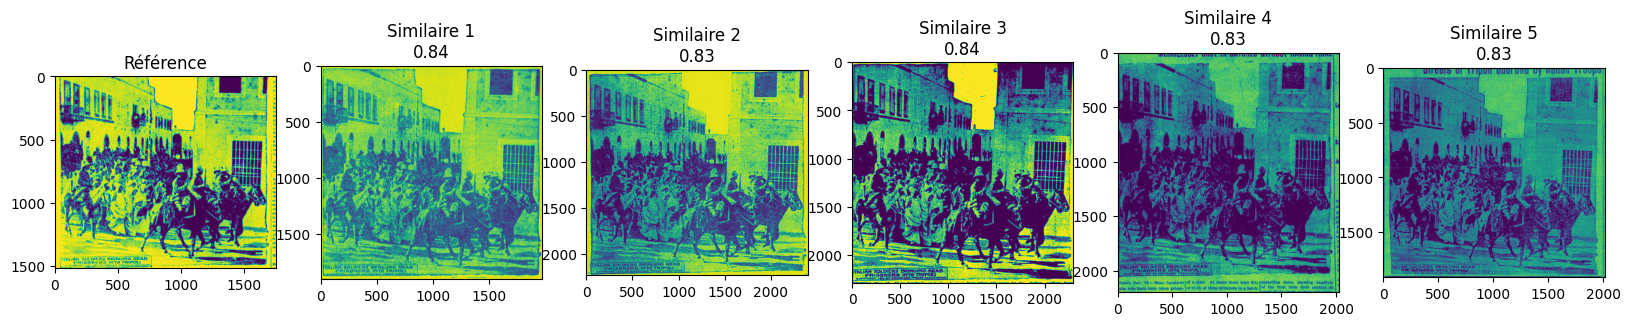

In [19]:
# Affichage des images similaires pour une l'image à l'indice n
n=10
reference_image_path = os.path.join(path_to_testset, list(top_similar_images_results.keys())[n])
similar_images_paths = [(os.path.join(path_to_testset, img), score) for img, score in top_similar_images_results[list(top_similar_images_results.keys())[n]]]
plot_subplots(reference_image_path, similar_images_paths)

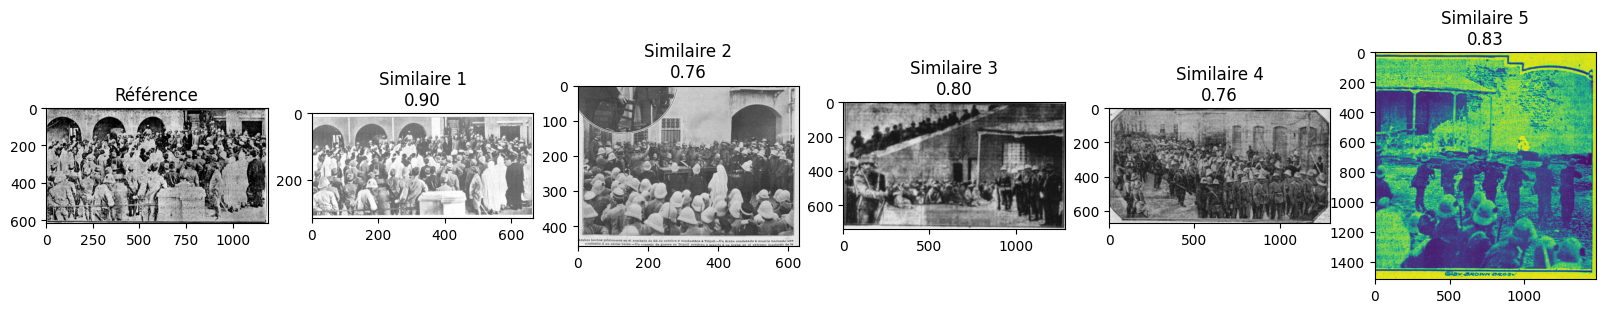

In [20]:
# Affichage des images similaires pour une l'image à l'indice n
n=0
reference_image_path = os.path.join(path_to_testset, list(top_similar_images_results.keys())[n])
similar_images_paths = [(os.path.join(path_to_testset, img), score) for img, score in top_similar_images_results[list(top_similar_images_results.keys())[n]]]
plot_subplots(reference_image_path, similar_images_paths)

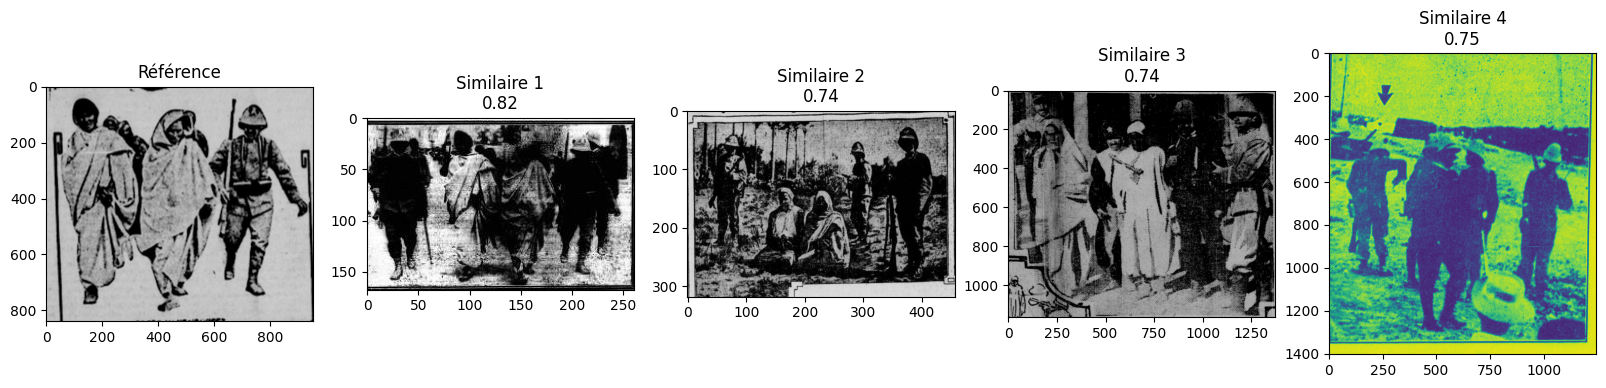

In [21]:
# Affichage des images similaires pour une l'image à l'indice n
n=20
reference_image_path = os.path.join(path_to_testset, list(top_similar_images_results.keys())[n])
similar_images_paths = [(os.path.join(path_to_testset, img), score) for img, score in top_similar_images_results[list(top_similar_images_results.keys())[n]]]
plot_subplots(reference_image_path, similar_images_paths)

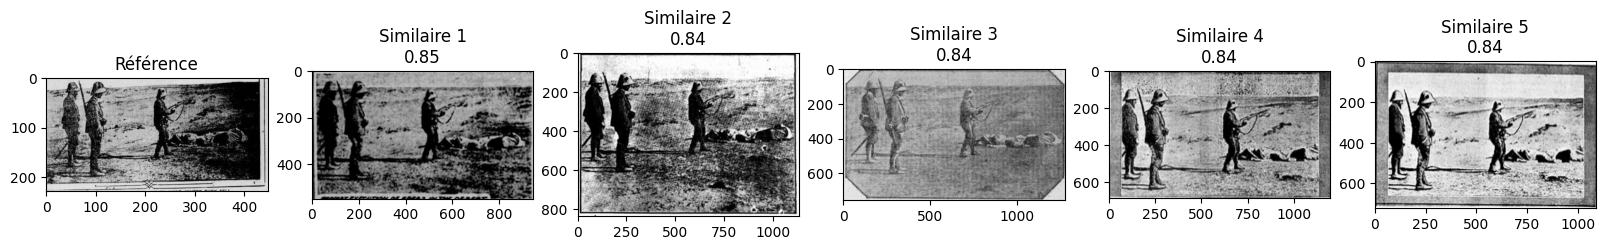

In [22]:
# Affichage des images similaires pour une l'image à l'indice n
n=30
reference_image_path = os.path.join(path_to_testset, list(top_similar_images_results.keys())[n])
similar_images_paths = [(os.path.join(path_to_testset, img), score) for img, score in top_similar_images_results[list(top_similar_images_results.keys())[n]]]
plot_subplots(reference_image_path, similar_images_paths)

# **Test sur des nouvelles images**

In [23]:
def search_in_database(reference_image_path, images_path, model, preprocess, device):
    # Prétraitement de l'image de référence
    reference_image = preprocess(Image.open(reference_image_path).convert("RGB")).unsqueeze(0).to(device)

    # Calcul des embeddings pour toutes les images de la base de données
    list_embeddings = []
    for img_path in images_path:
        image = preprocess(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)
        with torch.no_grad():
            embeddings = model.encode_image(image)
        list_embeddings.append(embeddings)

    # Concaténation et normalisation des embeddings
    embeddings = torch.cat(list_embeddings, dim=0)
    normalized_embeddings = embeddings / torch.norm(embeddings, dim=1, keepdim=True)

    # Calcul de la similarité cosinus entre l'image de référence et toutes les autres images
    with torch.no_grad():
        reference_embedding = model.encode_image(reference_image)
        normalized_reference_embedding = reference_embedding / torch.norm(reference_embedding, dim=1, keepdim=True)
        similarity_scores = normalized_embeddings @ normalized_reference_embedding.T

    # Retourner les scores de similarité et les chemins des images correspondantes
    return similarity_scores.squeeze().cpu().numpy(), images_path


In [24]:
def plot_similar_images(reference_image_path, similar_images_paths_scores):
    import matplotlib.pyplot as plt
    from matplotlib import gridspec

    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(1, len(similar_images_paths_scores) + 1, width_ratios=[1] * (len(similar_images_paths_scores) + 1))

    # Plot reference image
    ax0 = plt.subplot(gs[0])
    ax0.imshow(Image.open(reference_image_path))
    ax0.set_title("Référence")
    ax0.axis('off')

    # Plot similar images
    for i, (sim_image_path, sim_score) in enumerate(similar_images_paths_scores):
        ax = plt.subplot(gs[i + 1])
        ax.imshow(Image.open(sim_image_path))
        ax.set_title(f"Similaire {i + 1}\nScore: {sim_score:.2f}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [25]:
# Chemin vers la base de données d'images
path_to_testset = '/content/drive/MyDrive/projet/test_dataset'

# Liste des chemins des images dans la base de données
images_path = [os.path.join(path_to_testset, img_name) for img_name in os.listdir(path_to_testset)]

# Chemin de l'image de référence 
reference_image_path1 = '/content/drive/MyDrive/projet/new_test_set/test2.jpg'
images_path.append(reference_image_path1)
# Rechercher dans la base de données
similarity_scores, images_path = search_in_database(reference_image_path1, images_path, model, preprocess, device)

# Triez les indices des images en fonction des scores de similarité décroissants
sorted_indices = np.argsort(similarity_scores)[::-1]

# Afficher les 5 images les plus similaires
top_k = 5
similar_images_paths_scores = [(images_path[idx], similarity_scores[idx]) for idx in sorted_indices[:top_k]]




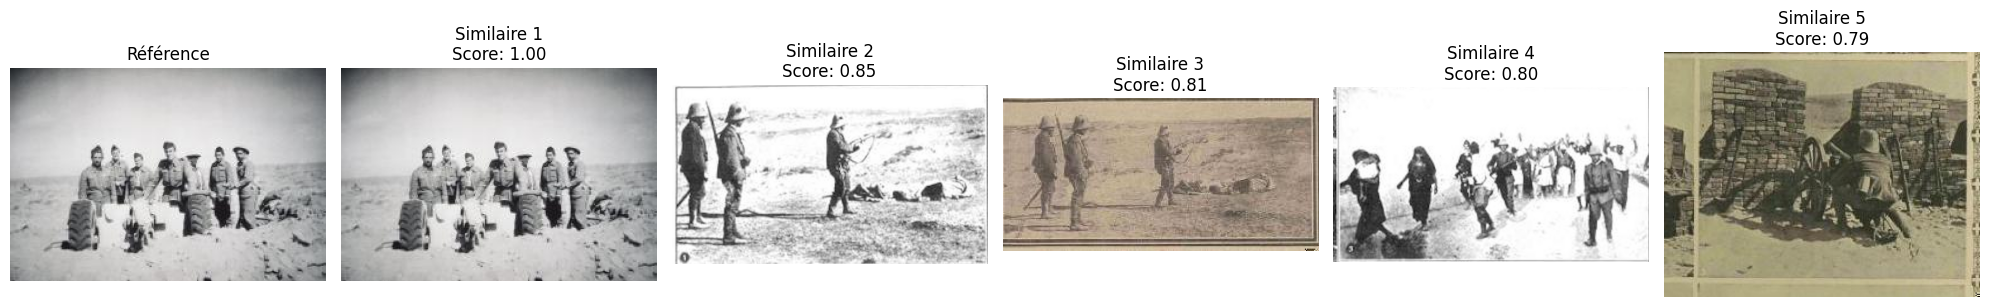

In [26]:
# Afficher les images similaires avec Matplotlib
plot_similar_images(reference_image_path1, similar_images_paths_scores)

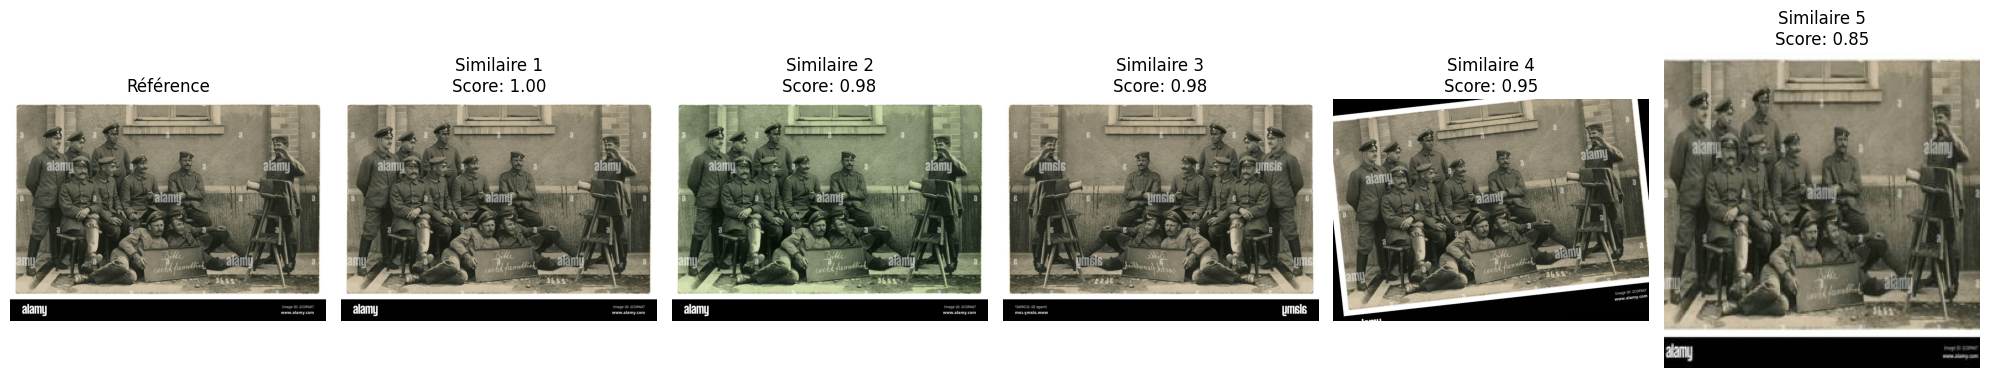

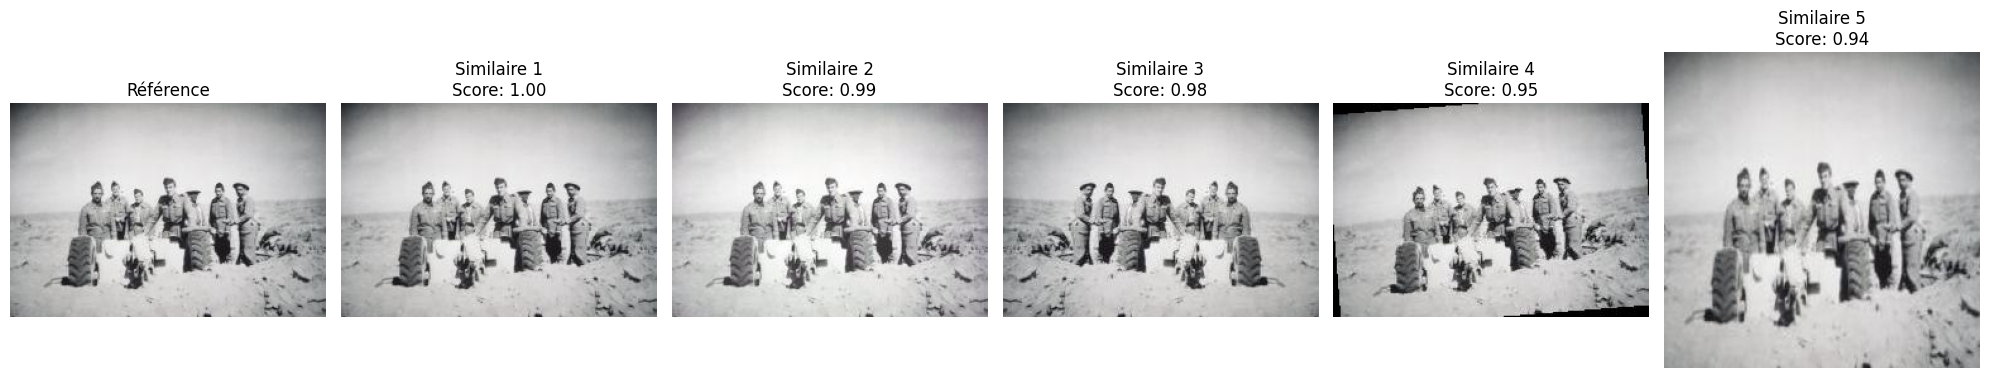

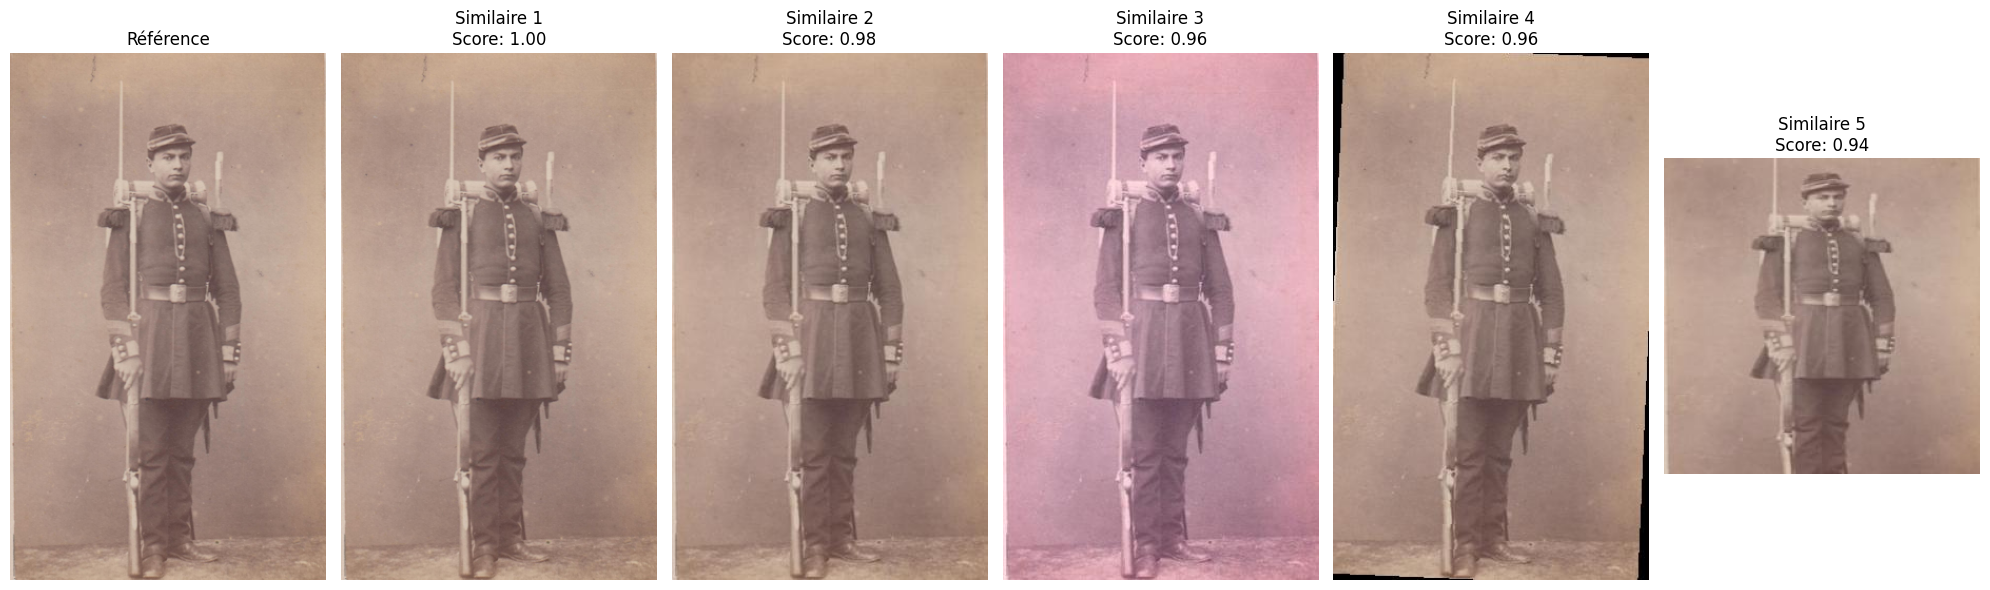

In [27]:
# Chemin vers la base de données d'images
path_to_testset = '/content/drive/MyDrive/projet/new_test_set_big'

# Liste des chemins des images dans la base de données
images_path = [os.path.join(path_to_testset, img_name) for img_name in os.listdir(path_to_testset)]

# Chemin de l'image de référence
reference_image_path1 = '/content/drive/MyDrive/projet/new_test_set/test1.jpg'
reference_image_path2 = '/content/drive/MyDrive/projet/new_test_set/test2.jpg'
reference_image_path3 = '/content/drive/MyDrive/projet/new_test_set/test3.jpg'

# Rechercher dans la base de données
for reference_image_path in [reference_image_path1, reference_image_path2, reference_image_path3]:
    similarity_scores, images_path = search_in_database(reference_image_path, images_path, model, preprocess, device)

    # Triez les indices des images en fonction des scores de similarité décroissants
    sorted_indices = np.argsort(similarity_scores)[::-1]

    # Afficher les 5 images les plus similaires
    top_k = 5
    similar_images_paths_scores = [(images_path[idx], similarity_scores[idx]) for idx in sorted_indices[:top_k]]

    # Afficher les images similaires avec Matplotlib
    plot_similar_images(reference_image_path, similar_images_paths_scores)
